In [59]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/brianbarry/Desktop/computing/personal/galaxybrain')
from galaxybrain import ramsey, ising
from galaxybrain.plot_utils import rc_style, pltlabel, plot_ising_spectra, measure_over_temps, TEMP_COLOR_RANGE, colorcycler, noticks,plot_all_measures
rc_style()

import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from matplotlib.colors import ListedColormap as lcmap
import pandas as pd

CRIT_T = 2.26918531421

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ising model and scaling correlation analysis
Hamiltonian – rate of change of the condition of a dynamic physical system, or total energy in the system – is given by

$$ H = -J\sum_{neighbors} s_is_j $$

Summing interactions between [4] neighbors, J (Strength of interaction in Joules) is usually 1 <br>
"In the case of an Ising system, instead of moving a particle, we switch the direction of its spin."

In each monte carlo sweep:
- "Propose" a move: (done in aggregate for each particle)
    - if ∆E < 0  (i.e., the move would bring the system to a state of lower energy; this is desired in physical systems), accept it
    - if ∆E > 0, accept move with probability exp(-∆E/kT) where k is Joules per kelvin.

let's try to do this vectorized

Fricke:  multiply every transition probability by 0.1 to avoid undesirable oscillatory regimes

References:
- [matlab code](https://www.asc.ohio-state.edu/braaten.1/statphys/Ising_MatLab.pdf)
- [python - how to find crit temp](https://rajeshrinet.github.io/blog/2014/ising-model/)

- orioginal tensor shape: (10000, 4096)
- 80% evals shape: 3276
- Taking off the last 2000: 1276

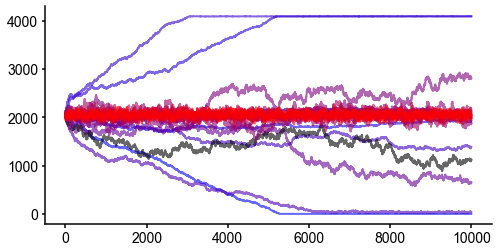

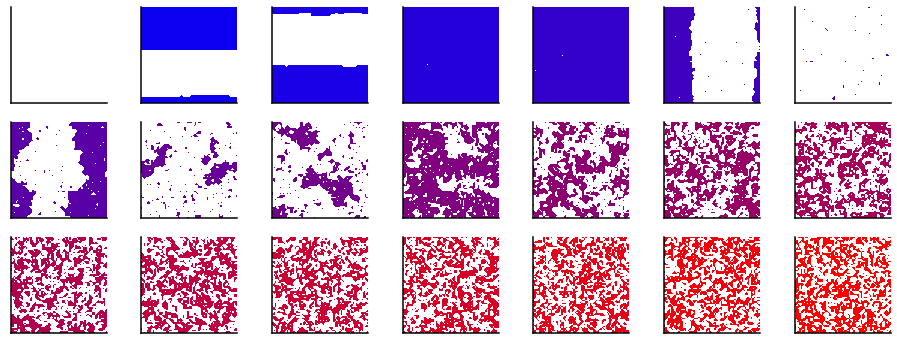

In [2]:
ising_h5 = h5py.File('/Users/brianbarry/Desktop/computing/personal/galaxybrain/data/spikes/ising.hdf5', 'r') 
temps = [float(i) for i in ising_h5.keys()]
COLORS = colorcycler(['blue', 'red'], len(ising_h5.keys()), default=False)
lws = {'2.27':4}
cs = {'2.27':'k'}
# all time series
plt.figure(figsize=(8,4))
for t,c in zip(ising_h5, COLORS):
    plt.plot(np.array(ising_h5[t]).sum(axis=-1).sum(axis=-1), label=t, color=cs.get(t,c), alpha=0.6)

# final frames
plt.figure(figsize=(16,6))
for i, (temp,c) in enumerate(zip(ising_h5, COLORS)):
    plt.subplot(3, 7, i+1)
    plt.imshow(ising_h5[temp][-1], cmap=lcmap(['w', c]))
    noticks()

### tensor analyzed

# Whole sample spectral analysis


In [4]:
def normalize(spec, low, high):
    """
    normalize around the coherently linear portion of the spectrum 
    (so that that portion overlaps, and deviations at lower freqs can be observed)
    
    TODO: low, high should be percentages
    """
    return spec/spec[low:high].sum()

# PSD

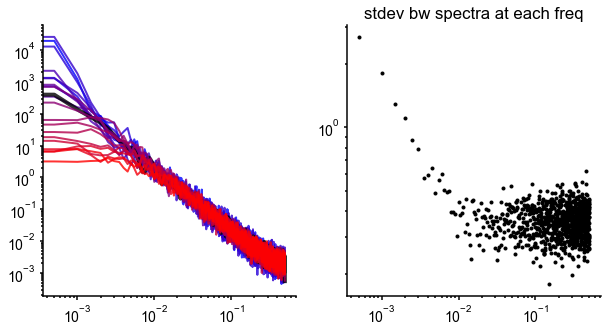

In [48]:
from neurodsp.spectral import compute_spectrum


# psds = []
# FS       = 1
# NPERSEG  = 2000 #400
# NOVERLAP = int(.8*NPERSEG)
# for temp in ising_h5:
#     ts = np.array(ising_h5[temp]).sum(axis=-1).sum(axis=-1)
#     freqs, spec = compute_spectrum(ts, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP)
#     psds.append(spec)
    
psds = np.array(psds)
normed_psds = np.array([normalize(spec, 500, 800) for spec in psds])
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for spec, t,c in zip(normed_psds, ising_h5, COLORS):
    plt.loglog(freqs, spec, label=t, color=cs.get(t,c), lw=lws.get(t, 2), alpha=0.8)
    
stdevs = np.array([np.std(slice_) for slice_ in np.log(normed_psds.T)])
plt.subplot(1,2,2)
plt.scatter(freqs, stdevs, color='k')
plt.title('stdev bw spectra at each freq')
plt.yscale('log'); plt.xscale('log')


# E Spec

take first n rows (e.g 30  -- > (4000, 30) ) and make sure number of pcs returned is n

Text(0.5, 1.0, 'x up to 0.54')

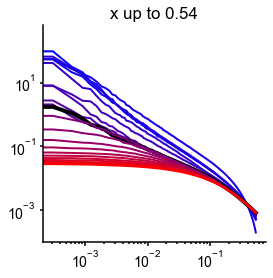

In [42]:
evals_h5 = h5py.File('/Users/brianbarry/Desktop/computing/personal/galaxybrain/data/experiments/ising_pca/ising_evals.hdf5', 'r') # keys := ['1.97', '2.07', '2.17', '2.27', '2.37', '2.47', '2.57']
orig_len = evals_h5['2.27'].shape[0]
evals = np.array([evals_h5[t] for t in evals_h5])
CUT_OFF = -1500
evals_plot = np.array([evals_h5[t][:CUT_OFF] for t in evals_h5])
plt.figure()
es_x = np.linspace(0,1, orig_len)
for e,t,c in zip(evals_plot, ising_h5, COLORS):
    plt.loglog(es_x[:CUT_OFF], normalize(e, 1000, 1700), color=cs.get(t,c), lw=lws.get(t, 2))
    # plt.loglog(es_x[:CUT_OFF], e, color=cs.get(t,c), lw=lws.get(t, 2))
plt.title(f'x up to {es_x[:CUT_OFF][-1]:.2f}')

In [5]:
evals_h5 = h5py.File('/Users/brianbarry/Desktop/computing/personal/galaxybrain/data/experiments/ising_pca/ising_evals.hdf5', 'r') # keys := ['1.97', '2.07', '2.17', '2.27', '2.37', '2.47', '2.57']
orig_len = evals_h5['2.27'].shape[0]
orig_len

3276

# right now
- pass down new fooof args


# FOOOF measures

In [142]:
from galaxybrain.ramsey import fooofy


def plot_fooof_measures(components, spec, fitting_ranges, return_params=[['aperiodic_params', 'exponent'],
                                                                         ['error'], # MAE
                                                                         ['aperiodic_params', 'offset']], **fooof_kwargs):
    """
    scatter plot of exponents, errors, offsets across temperatures
    
    -- input --
    components: x axis of spectrum frequencies or PCs
    spec: spectral values, of shape (n_temps, n_val)
    fitting_ranges: list of lists like [[low, high]...]
    """
    for x_range in fitting_ranges:
        plt.figure(figsize=(len(return_params)*4,4))
        for [i, val], name in zip(enumerate(fooofy(components, spec, x_range, return_params=return_params, **fooof_kwargs)), [p[-1] for p in return_params]):
            plt.subplot(1,len(return_params),i+1)
            plt.scatter(temps, val, c=COLORS, s=30)
            plt.title(name)
            plt.axvline(CRIT_T)
        plt.suptitle(f'range: {x_range}')

### PSD

['exponent', 'error', 'offset']


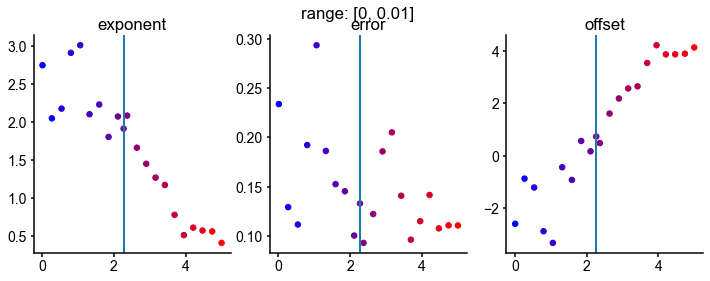

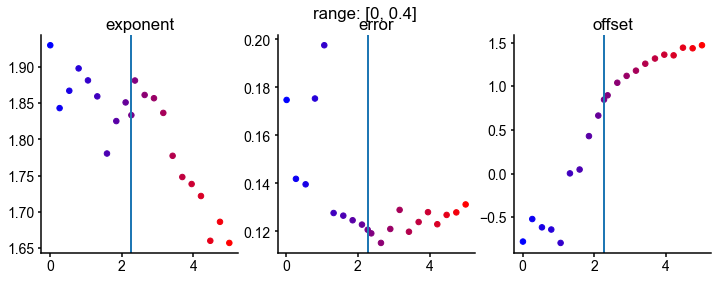

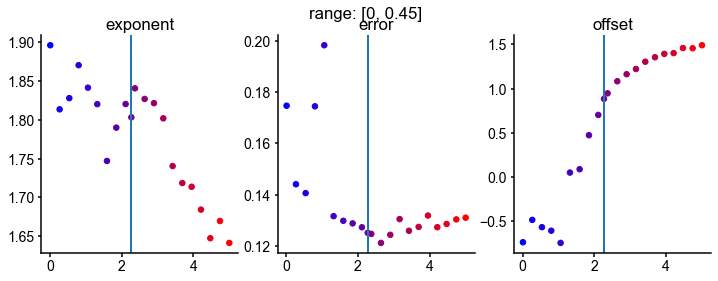

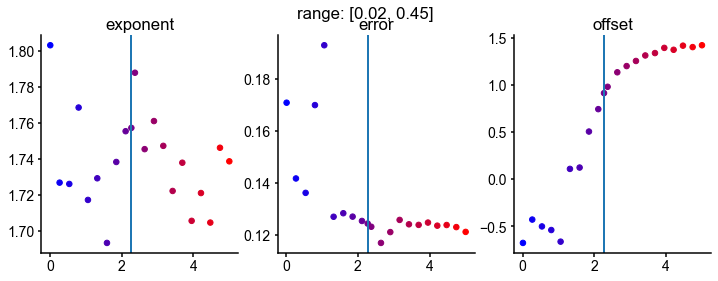

In [108]:
plot_fooof_measures(freqs, psds, [[0, 0.01], [0, 0.4], [0, 0.45], [0.02,0.45]])

### ES

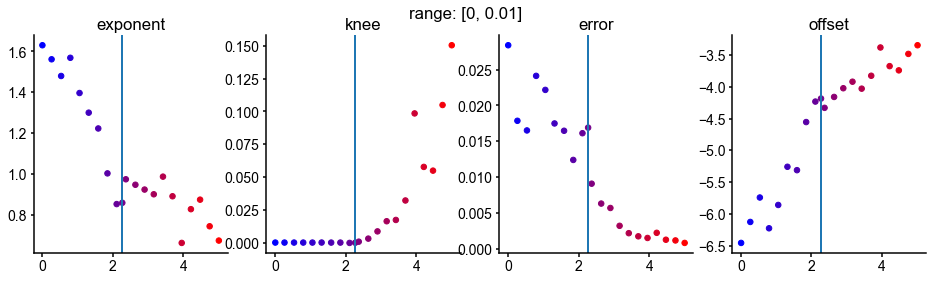

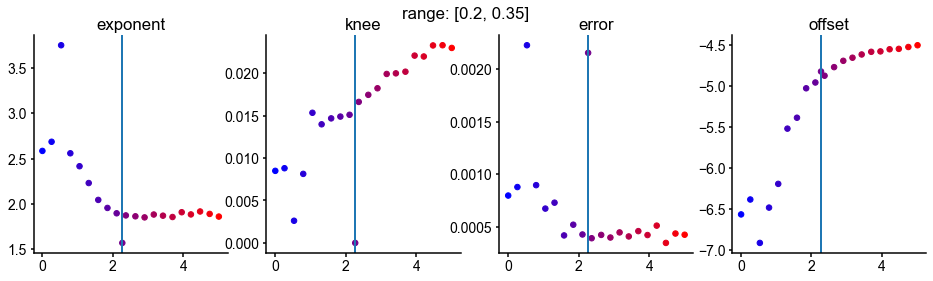

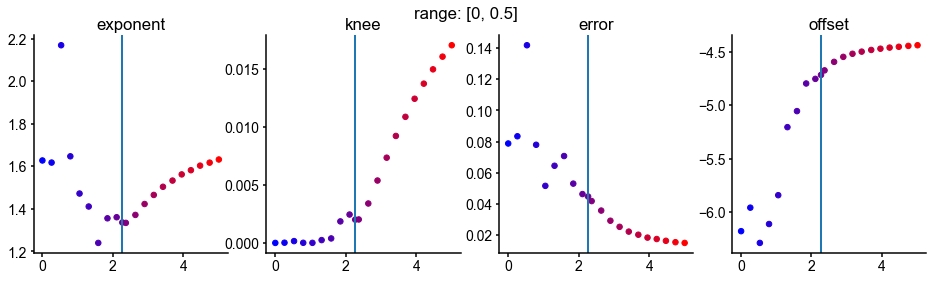

In [143]:
plot_fooof_measures(es_x, evals, 
                    [[0, 0.01], [0.2, 0.35], [0,0.5]], return_params=[['aperiodic_params', 'exponent'],
                                                                      ['aperiodic_params', 'knee'],
                                                                      ['error'], # MAE
                                                                      ['aperiodic_params', 'offset']], aperiodic_mode='knee')

# next steps

- find percentage for pc_range in analysis
- figure out PSD fitting range
- pass in fft args

# Diagram

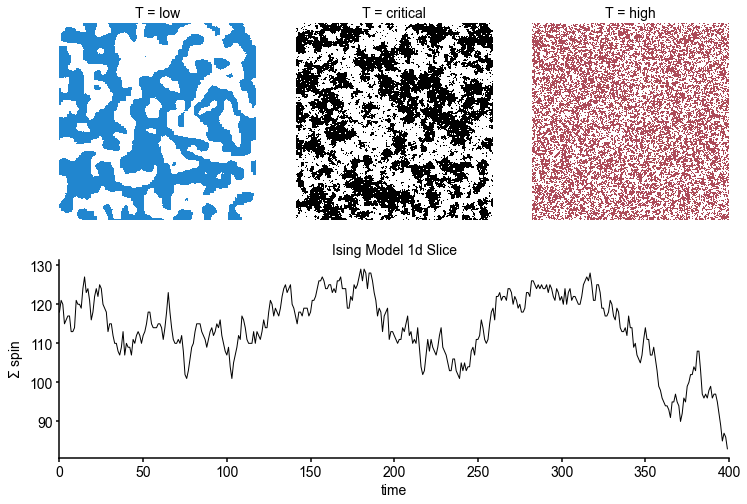

In [19]:
cs = TEMP_COLOR_RANGE[0], 'k', TEMP_COLOR_RANGE[1] #cold, crit, hot
fig = plt.figure(figsize=(12,8))
gs = GridSpec(2,3)
for (i, temp), c in zip(enumerate([0.1, 'critical', 5]), cs):
    # plt.subplot(1,3,i+1)
    ax = fig.add_subplot(gs[0,i])
    grid = ising.metro_ising(N=256, T=temp, runtime=500)
    ax.imshow(grid[499], cmap=lcmap(['w',c])) # plot last frame
    title_map = {0.1:'low', 'critical':'critical', 5:'high'}
    plt.title(f'T = {title_map[temp]}', fontsize=14)
    ax.axis('off')
    if temp == 'critical':
        ax = fig.add_subplot(gs[1,:])
        ising_raster_slice = pd.DataFrame(grid[100:][:,178]) # shape (400, 256)

        ax.plot(np.sum(ising_raster_slice.T), c, lw=1)
        plt.xlim([0,400])
        pltlabel('Ising Model 1d Slice', 'time', r'$\Sigma$ spin')
    
plt.savefig('../fig/ising/grid_samples.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# Subsampling analysis from cluster

Iterated 4 times for each temperature in: 0.50, 1.00, 1.27, 1.47, 1.67, 1.87, 2.07, 2.27, 2.47, 2.67, 2.87, 3.07, 3.27, 5.00

# important
because `n_pc=0.8` and `pc_range=[0,0.01`, there arent enough points to fooof fit so skip the first two subsetsizes 30,  301

In [113]:
from galaxybrain.data_utils import load_results

sim_data = load_results('../data/experiments/ising_better_fit', kind='sim')
all_temps = [k for k in sim_data if k != 'meta']

{'data_type': 'ising', 'n_iter': 25, 'n_pc': 0.8, 'pc_range': [0, 0.01], 'f_range': [0, 0.01], 'ft_kwargs': {'fs': 1, 'nperseg': 2000, 'noverlap': 1600}, 'fooof_kwargs': {'es': {'return_params': [['aperiodic_params', 'exponent'], ['aperiodic_params', 'knee'], ['error'], ['aperiodic_params', 'offset']], 'fit_kwargs': {'aperiodic_mode': 'knee'}}}}
1.06 doesn't have psd_error2
1.32 doesn't have psd_error2


In [119]:
sim_data.keys()

dict_keys(['2.11', '2.27', '1.85', '1.59', '2.64', '2.37', 'meta'])

In [106]:
sim_data['2.27']['meta']['subsetsizes']

array([  30,  301,  572,  843, 1114, 1385, 1656, 1927, 2198, 2469, 2740,
       3011, 3282, 3553, 3824, 4096])

# using mouse plot to look at one temp: Error in specplot because we skip couple firstsubset sizes

eigs


ValueError: x and y must have same first dimension, but have shapes (24,) and (457,)

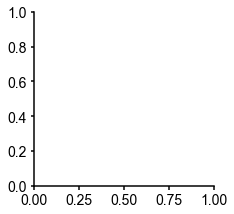

In [86]:
plot_all_measures(sim_data['2.27'], sim_data['meta'])

<ErrorbarContainer object of 3 artists>

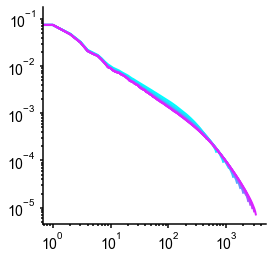

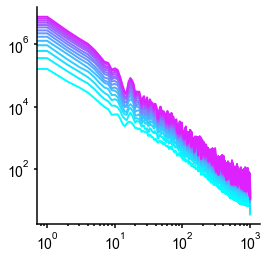

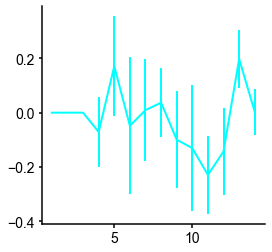

In [130]:
colors = list(iter(plt.cm.cool(np.linspace(0, 1, 16))))

for i, spec in enumerate(sim_data['2.27']['data']['eigs']):
    plt.loglog(spec, color=colors[i])
plt.figure()

for i, spec in enumerate(sim_data['2.27']['data']['pows']):
    plt.loglog(spec, color=colors[i])
    
    
plt.figure()
corr = sim_data['2.27']['data']['pearson_corr2'].T
x = list(range(len(corr)))
plt.errorbar(x[1:-1],corr[1:-1].mean(1), corr[1:-1].std(1))
# plt.plot(sim_data['2.27']['data']['pearson_corr1'].T)


In [117]:
import os
os.listdir('/Users/brianbarry/Desktop/computing/personal/galaxybrain/data/experiments/ising_better_fit')

['2.11',
 '2.27',
 '1.06',
 '1.85',
 '1.32',
 '1.59',
 '2.64',
 '2.37',
 'analysis_args.json']

In [175]:
fileName = 'ABCDPhantom001_18_month_follow_up_arm_1_SessionPHANTOM_1.2.840.113619.6.408.219462354693912423624126646992900363659_1.2.840.113619.2.408.4738430.14988326.28601.1541778440.186.md5sum_server'

eventNamePos = fileName.find('_')
pGUID = fileName[0:eventNamePos]
pGUID

'ABCDPhantom001'

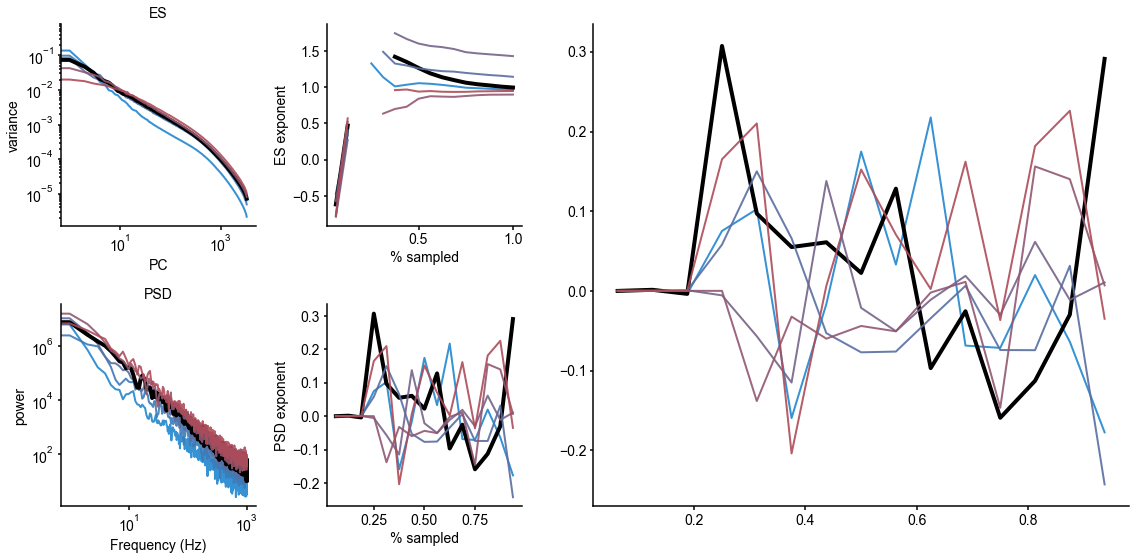

In [131]:

import os

sample_temps = ['1.59','1.85', '2.11', '2.27', '2.37', '2.64'] # want to `avoid big drop off with very low temps
fig = plt.figure(figsize=(16,8))
gs = GridSpec(2,3, width_ratios=[1,1, 2.75])

for (i, spec), labels in zip(enumerate(['eigs', 'pows']), 
                           [['ES','PC', 'variance'], ['PSD','Frequency (Hz)', 'power']]):
    ax = fig.add_subplot(gs[i, 0])
    plot_ising_spectra(sim_data, spec, sample_temps, subset_ix=13, ax=ax)
    pltlabel(*labels)

for (i, spec), labels in zip(enumerate(['es_exponent', 'spearman_corr1']), 
                           [['','% sampled', 'ES exponent'], ['','% sampled', 'PSD exponent']]):
    ax = fig.add_subplot(gs[i, 1])
    measure_over_temps(sim_data, spec, all_temps, ax=ax)
    pltlabel(*labels)
    
ax = fig.add_subplot(gs[:,2])
measure_over_temps(sim_data, 'spearman_corr1', all_temps, ax, colorbar=False)
# pltlabel('', '% sampled', 'correlation')
fig.tight_layout()

# plt.savefig('../fig/ising/specs_corr.png', bbox_inches='tight', pad_inches=0.0, dpi=400)